In [ ]:
import numpy as np
import pandas as pd
import os, re

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla T4


In [ ]:
# Load data
df = pd.read_excel('PHQ9DepressionNLP_elaborated.xlsx')
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

Number of training sentences: 520



In [ ]:
# Concatenate the descriptions and store them in a new column 'statements'
df['statements'] = df.apply(lambda row: ' '.join([str(row['PHQDescription']),
                                                  str(row['ViolenceDescription']),
                                                  str(row['PressureDescription']),
                                                  str(row['SocialDescription']),
                                                  str(row['AcademicDescription'])]), axis=1)


In [ ]:
# Initialize GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Define the few-shot examples
few_shot_examples = [
    {"statement": df['statements'][0], "label": df['PHQ9_levels'][0]},
    {"statement": df['statements'][1], "label": df['PHQ9_levels'][1]},
    {"statement": df['statements'][2], "label": df['PHQ9_levels'][2]},
]


In [ ]:
few_shot_examples[0]

{'statement': "I often feel a lack of interest in activities, described as I get as much satisfaction out of things as I used to. satisfaction, and I've been feeling down I feel sad. My sleep quality is I don't sleep as well as I used to., and I often feel fatigued I don't get more tired than usual.. My appetite level is My appetite is no worse than usual., and I frequently feel bad about myself due to fear of failure, described as I feel I have failed more than the average person.. I have trouble making decisions I make decisions about as well as I ever could., feel agitated Fidgetiness/ (অস্থিরতা), and have had suicidal feelings Absent.. I  Disagree that I experienced physical violence, I  Disagree that I experienced sexual violence, I  Agree that I experienced verbal violence, and I Disagree that I experienced emotional violence. I  Agree that my Parents are Strict. I  Agree that I experienced Academic Pressure from my parents, I  Agree that I experienced Marriage Pressure from my p

In [ ]:
# Create a mapping from labels to integers
label_mapping = {label: idx for idx, label in enumerate(df['PHQ9_levels'].unique())}
print(f"Label Mapping: {label_mapping}")

Label Mapping: {'Minimal': 0, 'Moderate': 1, 'Mild': 2, 'ModeratelySevere': 3, 'Severe': 4}


In [ ]:
def format_few_shot_prompt(examples, new_statement):
    prompt = ""
    for example in examples:
        prompt += f"Statement: {example['statement']}\nLabel: {example['label']}\n\n"
    prompt += f"Statement: {new_statement}\nLabel:"
    return prompt

In [ ]:
epochs = 30

In [ ]:

# Training loop - not traditional fine-tuning but structuring the input prompts
def train_few_shot(model, tokenizer, few_shot_examples, new_statements, labels):
    model.train()
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    losses = []  # To store the loss values for plotting

    for epoch in range(epochs):  # Few-shot usually requires very few epochs
        total_loss = 0.0
        for new_statement, label in zip(new_statements['statements'], new_statements['PHQ9_levels']):
            prompt = format_few_shot_prompt(few_shot_examples, new_statement)
            inputs = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

            # Generate outputs
            outputs = model(inputs, labels=inputs)

            # Calculate loss using the model's logits and the label
            logits = outputs.logits
            target_label = torch.tensor([label_mapping[label]], dtype=torch.long).to(device)
            loss = torch.nn.CrossEntropyLoss()(logits[:, -1, :], target_label)

            model.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_loss = total_loss / len(new_statements)
        losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")

    # Plot the loss variation with epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Variation')
    plt.grid(True)
    plt.legend()
    plt.show()

    return losses

In [ ]:
def test_few_shot(model, tokenizer, few_shot_examples, test_statement):
    prompt = format_few_shot_prompt(few_shot_examples, test_statement)
    inputs = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate with a limit on max new tokens and a specific maximum length
    outputs = model.generate(inputs, max_length=1024, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the predicted label
    predicted_label = generated_text.split("Label:")[-1].strip().split("\n")[0].strip()

    return predicted_label


In [ ]:
# Split data into training and testing
new_statements, test_data = train_test_split(df, test_size=0.2, random_state=42)

Epoch 1, Loss: 2.060073173461625
Epoch 2, Loss: 1.6335446282934685
Epoch 3, Loss: 1.5899131269409106
Epoch 4, Loss: 1.5854477774208555
Epoch 5, Loss: 1.5565860901171198
Epoch 6, Loss: 1.5494975179720383
Epoch 7, Loss: 1.5601491022568483
Epoch 8, Loss: 1.5385475889421427
Epoch 9, Loss: 1.5454548070063958
Epoch 10, Loss: 1.5215866072819784
Epoch 11, Loss: 1.540695675003987
Epoch 12, Loss: 1.5211114714351983
Epoch 13, Loss: 1.5373646810364265
Epoch 14, Loss: 1.5234585818476403
Epoch 15, Loss: 1.516852637896171
Epoch 16, Loss: 1.5060231923483884
Epoch 17, Loss: 1.5131564934093218
Epoch 18, Loss: 1.5117429930430193
Epoch 19, Loss: 1.5159976274634783
Epoch 20, Loss: 1.5211475078876202
Epoch 21, Loss: 1.504549552471592
Epoch 22, Loss: 1.5155287300451443
Epoch 23, Loss: 1.505304615944624
Epoch 24, Loss: 1.5003749137887588
Epoch 25, Loss: 1.5037517567666678
Epoch 26, Loss: 1.505797465546773
Epoch 27, Loss: 1.5064016968871539
Epoch 28, Loss: 1.4969010590933836
Epoch 29, Loss: 1.5012736463776002


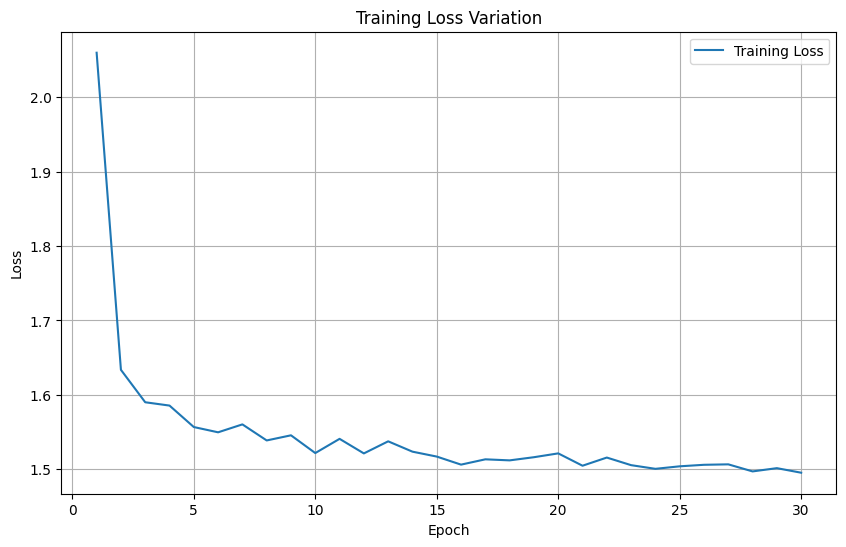

In [ ]:
# Example usage for training
train_losses = train_few_shot(model, tokenizer, few_shot_examples, new_statements, new_statements)

In [ ]:
# Example usage for evaluation
predicted_labels = []
true_labels = []

In [ ]:
predicted_labels

[]

In [ ]:
for index, row in test_data.iterrows():
    test_statement = row['statements']
    true_label = row['PHQ9_levels']

    predicted_label = test_few_shot(model, tokenizer, few_shot_examples, test_statement)
    predicted_labels.append(predicted_label)
    true_labels.append(true_label)

In [ ]:
# Print classification report
report = classification_report(true_labels, predicted_labels, zero_division=0)
print(report)

                  precision    recall  f1-score   support

            Mild       0.00      0.00      0.00        29
         Minimal       0.29      1.00      0.45        30
        Moderate       0.00      0.00      0.00        28
ModeratelySevere       0.00      0.00      0.00        11
          Severe       0.00      0.00      0.00         6

        accuracy                           0.29       104
       macro avg       0.06      0.20      0.09       104
    weighted avg       0.08      0.29      0.13       104



In [ ]:
from sklearn.metrics import accuracy_score
# Calculate accuracy separately
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.28846153846153844


In [ ]:
# # Function to evaluate model
# def evaluate_model(model, tokenizer, few_shot_examples, test_data):
#     predicted_labels = []
#     true_labels = []

#     for test_statement, true_label in zip(test_data['statements'], test_data['PHQ9_levels']):
#         predicted_label = test_few_shot(model, tokenizer, few_shot_examples, test_statement)
#         predicted_labels.append(predicted_label)
#         true_labels.append(true_label)

#     # Print classification report
#     report = classification_report(true_labels, predicted_labels, zero_division=0)
#     print(report)

#     # Calculate accuracy separately
#     accuracy = accuracy_score(true_labels, predicted_labels)

#     return accuracy

In [ ]:
# # Example usage for evaluation
# test_data = df.iloc[6:10]  # Adjust this based on how you split your data for testing
# accuracy = evaluate_model(model, tokenizer, few_shot_examples, test_data)

# print(f"Accuracy: {accuracy}")
